In [6]:
#Load edges and nodes

import numpy as np
from load_data import *

nodes_array, edge_array = assert_edges_are_within_first_cluster()

node_lookup_dict = {}

min_index = np.amin(nodes_array)
max_index = np.amax(nodes_array)


i = 0
for node in nodes_array:
    node_lookup_dict[str(node)] = i
    i+= 1
    
adj_matrix = np.load('adj_matrix.npy')    
data_dir = '../data/'

98753it [00:00, 888338.16it/s]
2004it [00:00, 1194625.53it/s]


In [ ]:
#Get dois from the exosome csv
#Read the DOIS from the node id

from load_data import *

import csv

csv_file_path = data_dir + 'exosome.csv'
doi_lookup_dict = {}

# Open the CSV file for reading
with open(csv_file_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    dois = {}
    for line_number, row in tqdm(enumerate(csv_reader), total = 14695476):  # 'total' is the total number of iterations
        
        if line_number <min_index or line_number > max_index:
            continue
            
        id = str(row[0])
        doi = row[2]
        
        if id in node_lookup_dict:
            doi_lookup_dict[id] = doi



  4%|▍         | 587841/14695476 [00:01<00:31, 451482.81it/s]

In [ ]:
#Save
import json

with open('first_cluster_dois.json', 'w') as json_file:
    json.dump(doi_lookup_dict, json_file, indent=4)
    

In [ ]:
#Get PMID by doi

import requests
import xmltodict

doi_dict = {}

#Get dois
def fetch_pmid_from_doi(doi='10.1073/pnas.0510928103'):

    pmid_dict = {}
    request_str = 'https://www.ncbi.nlm.nih.gov/pmc/utils/idconv/v1.0/?tool=my_tool&email=my_email@example.com&ids='
    request_str += str(doi)
    
    response = requests.get(request_str)
    response_text = response.text
    
    if response.status_code == 200:
        index = response_text.index('pmid=')


        pmid_whole = response_text[index:].split(' ')[0]
        pmid = int(pmid_whole[:-1].split('\"')[1])

        return pmid
    
    else:
        return 0
    

for key in tqdm(node_lookup_dict.keys()):
    doi_dict[key] = fetch_pmid_from_doi(key)
    

In [ ]:
#It turns out that initial node ids is their PMID


for key, value in doi_dict.items():
    assert key == value
    

with open('first_cluster_pmid.json', 'w') as json_file:
    json.dump(doi_dict, json_file, indent=4)
    

In [ ]:
import json

with open('first_cluster_pmid.json', 'r') as json_file:
    doi_dict = json.load(json_file)
    
pmid_dict = doi_dict

In [ ]:
#Save all xmls
all_xmls = {}
def save_all_xmls(pmid):
    wait = 0.25
    time.sleep(wait)
    pmid_dict = {}
    request_str  = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id='
    request_str += str(pmid)
    
    response = requests.get(request_str)
    response_text = response.text
    
    try:
        xml_dict = xmltodict.parse(response_text)
        
    except:
        time.sleep(2 * wait)
        return fetch_metadata_from_pmid(pmid)
    
    return response_text

# for id in tqdm(pmid_dict):
#     all_xmls[id] = save_all_xmls(id)

with open('first_cluster_xmls.json', 'w') as json_file:
    json.dump(all_xmls, json_file, indent=4)
    




In [8]:
#Load all XMLs
import json

with open('first_cluster_xmls.json', 'r') as json_file:
    all_xmls = json.load(json_file)
    

    

In [54]:
#Mispelled
import time
import requests
import xmltodict

parsed_error = []
dict_of_interest = {'keyword': 0, "grantlist": 0, "meshheadinglist": 0, "chemicallist":0, 'datecompleted': 0, 'journal': 0}
journal_title_lookup_dict = {}
journal_ISSN_lookup_dict = {}

def fetch_metadata_from_pmid(response_text, idx, pmid): 
    global dict_of_interest
    mesh_headings = []
    grants = []
    year = ""
    journal_ISSN = ""
    abstract = ""
    chemical_list = []
    meta_data = {}
    journal_title = ""
    pub_year = ""

    try:
        xml_dict = xmltodict.parse(response_text)
        if len(str(xml_dict))< 300:
            parsed_error.append(pmid)
            raise 'no data'
        
        for key_of_interest in dict_of_interest.keys():
            if key_of_interest in str(xml_dict).lower():

                dict_of_interest[key_of_interest] += 1

        #Date completed or revised?
        #print(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation'].keys())
        
        
        try:
            if 'DateCompleted' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']:
                if 'Year' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['DateCompleted']:
                    year = xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['DateCompleted']['Year']

            else:
    #             print(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation'])
                  pass
    
        except:
            pass


        
        try:
            if 'JournalIssue' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['Journal'].keys():
                if 'PubDate' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['Journal']['JournalIssue']:
                    if 'Year' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']:
                        pub_year = xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']['Year']
                        
            if 'ISSN' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['Journal'].keys():
                journal_ISSN = xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['Journal']['ISSN']['#text'] 
            
            if 'Title' in  xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['Journal'].keys():
                journal_title = xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['Journal']['Title']
                
            if len(journal_ISSN) > 0 and len(journal_title)>0:
                journal_ISSN_lookup_dict[journal_ISSN] = journal_title
                journal_title_lookup_dict[journal_title] = journal_ISSN
                
            elif len(journal_ISSN) == 0:
                if journal_title in journal_title_lookup_dict:
                    journal_ISSN = journal_title_lookup_dict[journal_title]
                    
            elif len(journal_title) == 0:
                if journal_ISSN in journal_ISSN_lookup_dict:
                    journal_title = journal_ISSN_lookup_dict[journal_ISSN]                
                
                
        except Exception as e:
            print(e, pmid)
        #print(len(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['GrantList']['Grant']))
        
        
        #Grant
        #Very few grants don't have grant id's
        #Grant institute could also be relevant
        #TODO: collect missing grant id

        try:
            if 'GrantList' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']:
                if type(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['GrantList']['Grant']) == list:
                    for grant in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['GrantList']['Grant']:
                        if 'GrantID' in grant:
                            grants.append((grant['GrantID']))
                            
                else:
                     grants.append(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['GrantList']['Grant']['GrantID'])
                     pass   
        except:
            pass
        
        
 

        #print(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['GrantList']['Grant'][0])
        
        #MeSH heading  
        
        try:
        #print(len(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['MeshHeadingList']['MeshHeading']))
        
            #DescriptorName? Is a term
            if 'MeshHeadingList' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']:
                if type(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['MeshHeadingList']['MeshHeading']) == list:
                    for mesh in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['MeshHeadingList']['MeshHeading']:
    #                 print(mesh['DescriptorName'])
    #                 print(mesh['DescriptorName']['@UI'])
    #                 print(mesh['DescriptorName']['#text'])
    
                        if '@Type' in mesh['DescriptorName'].keys() and mesh['DescriptorName']['@Type'] == 'Geographic':
                            continue
                
                
                        mesh_headings.append((mesh['DescriptorName']['@UI'], mesh['DescriptorName']['#text']))
            
                else:
                    mesh = xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['MeshHeadingList']['MeshHeading']['DescriptorName']
                    if  (not '@Type' in mesh.keys() or mesh['@Type'] != 'Geographic'):
                        mesh_headings.append((xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['MeshHeadingList']['MeshHeading']['DescriptorName']['@UI'],
                                            xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['MeshHeadingList']['MeshHeading']['DescriptorName']['#text']))
        except:
            pass
        
        
        try:
        #print(len(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['MeshHeadingList']['MeshHeading']))
        
            #DescriptorName? Is a term
            if 'ChemicalList' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']:
#                print(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']
# #                      ['ChemicalList']['Chemical']['NameOfSubstance'])
               #print(len(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['ChemicalList']['Chemical']))
               if type(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['ChemicalList']['Chemical']) == list:
                   for substance in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['ChemicalList']['Chemical']:
                            chemical_list.append(substance['NameOfSubstance']['@UI'])
                        
               else:
                   chemical_list.append(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['ChemicalList']['Chemical']['NameOfSubstance']['@UI'])
                #print(chemical_list)
                
               
              

        except:
            pass
        


        #References and history
        #print(xml_dict['PubmedArticleSet']['PubmedArticle']['PubmedData'].keys())


    except:
        pass


    if len(year) == 0:
        year = pub_year
        
    meta_data = {'mesh': mesh_headings, 'grants': grants, 'year': year, 'journal_ISSN': journal_ISSN,
                 'journal_title': journal_title,'chemical' : chemical_list, 'pub_year': pub_year} 
        
    return meta_data

metadata_dict = {}

# [166, 719, 1672, 1918] odd

idx = 0
for key, value in tqdm(all_xmls.items()):
    metadata_dict[key] = fetch_metadata_from_pmid(value, idx, key)
    idx += 1
    


print(f'failed parse {len(parsed_error)} which are: {parsed_error}')
print(f'Occured keyword dict: {dict_of_interest}')

100%|██████████| 2004/2004 [00:03<00:00, 515.98it/s]

failed parse 11 which are: ['11460150', '12335001', '5162804', '332795', '62782', '9877917', '4447963', '11441495', '12163935', '5377235', '410866']
Occured keyword dict: {'keyword': 19, 'grantlist': 137, 'meshheadinglist': 1990, 'chemicallist': 1085, 'datecompleted': 1991, 'journal': 1993}


Turns out that out of 2004 papers of CEN cluster1, 11 of those don't have any metadata. That leaves us with 1993 samples. The above dictionary tells us the frequence of keyword occurence. The bellow one tells us the frequency of actual recorded value.

In [55]:
#### Count incomplete data

features = {'mesh': 0, 'grants': 0, 'year': 0, 'journal_title': 0, "journal_ISSN":0, 'chemical' : 0, 'pub_year': 0}
#Mesh terms are sometimes unrelated

mesh_length = []
chemical_length = []

for feature in features.keys():
    for _, meta in metadata_dict.items():
        if len(meta[feature]) > 0:
            features[feature] += 1
            if feature == 'mesh':
                mesh_length.append(len(meta[feature]))
            
            elif feature == 'chemical':
                chemical_length.append(len(meta[feature]))
                
            
print("recorded features ", features)
print(f"avg mesh length: {np.mean(mesh_length)} std: {np.std(mesh_length)}" )
print(f"avg chemical length: {np.mean(chemical_length)} std: {np.std(chemical_length)}")

recorded features  {'mesh': 1990, 'grants': 136, 'year': 1993, 'journal_title': 1993, 'journal_ISSN': 1960, 'chemical': 1085, 'pub_year': 1982}
avg mesh length: 9.399497487437186 std: 4.473675065502884
avg chemical length: 3.3788018433179725 std: 2.542416652594202


In [ ]:
import json

with open('first_cluster_metadata.json', 'w') as json_file:
    json.dump(metadata_dict, json_file, indent=4)
    


In [ ]:
import json

# Load the metadata file
with open('first_cluster_metadata.json', 'r') as json_file:
    metadata_dict = json.load(json_file)

In [59]:
def calculate_dict_similarity(dict_1, dict_2, mode ): 
    similarity = 0
    modes = ['number_of_common_terms', 'jaccard']
    
    assert mode in modes
    
    for key in dict_1:
            if key in dict_2:
                similarity += 1
                
    
    if mode == 'number_of_common_terms':
        pass
       
    elif mode == 'jaccard':
        similarity = similarity / (len(dict_1) + len(dict_2))
        
    
    return similarity

<h1>Checking for same grants</h1> <p> Let's simply record number of same grants. It turns out no two papers have same grant</p>

In [60]:
#Calculate similarity between two pmid's
#Lets call it metric for now. This is unnormalized
def calculate_similarity(pmid1, pmid2, feature):
    
    metric = 0
    pmid1 = str(pmid1)
    pmid2 = str(pmid2)
    
    assert feature in ['year', 'mesh', 'chemical', 'co-citation', 'bib-coupling', 'grants', 'journal']
    if feature == 'year':             
                year1 = metadata_dict[pmid1][feature]
                year2 = metadata_dict[pmid2][feature]
                
                if len(year1) > 0 and len(year2)>0:
                    metric = np.abs(int(year1)-int(year2))
                
                else:
                    metric = -1
                    
    if feature == 'journal':
        issn1 = metadata_dict[pmid1]['journal_ISSN']
        issn2 = metadata_dict[pmid2]['journal_ISSN']
        
        title1 = metadata_dict[pmid1]['journal_title']
        title2 = metadata_dict[pmid2]['journal_title']
        
        
        if len(issn1)>0 and len(issn2)>0:
            metric = int(issn1==issn2)
        
        
  
        elif len(title1)>0 and len(title2)>0:
            metric = int(title1==title2)
            
        
        else:
            metric = -1
            
            
        
        
    
    
    #They are both treated the same way ...
    elif feature == 'mesh' or feature == 'chemical':
        common_terms = 0
        terms_1 = {}
        terms_2 = {}
        
        for term in metadata_dict[pmid1][feature]:
            terms_1[term[0]] = 1
    
        for term in metadata_dict[pmid2][feature]:
            terms_2[term[0]] = 1
        
        if len(terms_1) > 0 and len(terms_2)>0:
            metric = calculate_dict_similarity(terms_1, terms_2, 'jaccard')
                    
        else:
            metric = -1
            
    elif feature == 'bib-coupling':
        node_1 = node_lookup_dict[pmid1]
        node_2 = node_lookup_dict[pmid2]
        
        common = np.dot(adj_matrix[node_1,:], adj_matrix[node_2, :])
        denom = np.sum(adj_matrix[node_1, :]) + np.sum(adj_matrix[node_2, :]) - common
        
        if denom > 0 :
            metric = common / denom
        
    
    elif feature == 'co-citation':
        node_1 = node_lookup_dict[pmid1]
        node_2 = node_lookup_dict[pmid2]
        
        common = np.dot(adj_matrix[: , node_1], adj_matrix[: , node_2])
        denom = np.sum(adj_matrix[:, node_1]) + np.sum(adj_matrix[:, node_2]) - common
        
        if denom > 0 :
            metric = common / denom
            
    
    elif feature == 'grants':
        grants_1 = metadata_dict[pmid1]['grants']
        grants_2 = metadata_dict[pmid2]['grants']
       
        
        for first in grants_1:
            for second in grants_2:
                if first == second:
                    metric +=1
                    
    return metric

In [61]:
def calculate_three_hop_similarity():
    #Is currently inefficient as relies on matrix multiplication
    # We use undirected edges
    aggregated_three_hop_similarity = np.zeros_like(adj_matrix)
    undirected_adj_matrix = adj_matrix + adj_matrix.transpose()
    second_hop_distance = np.matmul(undirected_adj_matrix, undirected_adj_matrix)
    
    three_hop_distance = np.matmul(second_hop_distance, undirected_adj_matrix)
    
    for i in range(adj_matrix.shape[0]):
        for j in range(i):
            similarity = 0
            if undirected_adj_matrix[i][j] == 1:
                similarity = 1
            
            elif second_hop_distance[i][j] > 0:
                similarity = 2/3
            
            elif three_hop_distance[i][j] > 0:
                similarity = 1/3
            
            aggregated_three_hop_similarity[i][j] = similarity
    
    aggregated_three_hop_similarity = aggregated_three_hop_similarity + aggregated_three_hop_similarity.transpose()
    return aggregated_three_hop_similarity

aggregated_three_hop_similarity = calculate_three_hop_similarity()
np.save('aggregated_three_hop_similarity.npy', aggregated_three_hop_similarity)
    

In [62]:
#all mesh terms are tuples, so we use UI's as they are standard

ones = 0
twos = 0

for key, value in metadata_dict.items():
    if len(value['mesh']) >0:
        for mesh in value['mesh']:
            if len(mesh) == 1:
                ones += 1
            
            elif len(mesh) == 2:
                twos += 1
            
            else:
                raise 'error'
            
print(f'Mesh terms with one entires {ones}')
print(f'Mesh terms with two entires {twos}')
print(f'Example of a mesh: {mesh}')


Mesh terms with one entires 0
Mesh terms with two entires 18705
Example of a mesh: ('D015046', 'Zoology')


In [63]:
import matplotlib.pyplot as plt


def report_stats(vals, title):
    filtered_val = []
    for val in vals:
        if val != -1:
            filtered_val.append(val)
            
    median = np.median(filtered_val)
    mean = np.mean(filtered_val)
    min = np.amin(filtered_val)
    max = np.amax(filtered_val)
    total = np.sum(filtered_val)
    
    fig = plt.figure(figsize=(10, 7))
#     fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')

    ax = fig.add_subplot(111)
    ax.boxplot(vals)
    
    labels = [title]

    ax.set_xticklabels(labels)

    ax.set_title(f'{title}  boxplot diagram')
#     ax.set_xlabel(f'{title}')
    ax.set_ylabel('Values')

    plt.show()


    print(f'median {median} mean {mean} min {min} max {max} total {total}')

    

def calculate_similarity_matrix(feature):
    similarity_matrix = np.zeros((len(nodes_array), len(nodes_array))) 
    
    for i in tqdm(range(similarity_matrix.shape[0])):
        for j in range(i):
            pmid1 = str(nodes_array[i])
            pmid2 = str(nodes_array[j])            
            similarity_matrix[i][j] = calculate_similarity(pmid1, pmid2, feature)
        
    similarity_matrix = similarity_matrix + similarity_matrix.transpose()
    
    #Year is the only feature that is initially distance and needs to be similarity
    if feature == 'year':
        similarity_matrix = np.ones_like(similarity_matrix) - similarity_matrix/np.amax(similarity_matrix)
        similarity_matrix = np.where(similarity_matrix > 1, -1, similarity_matrix)
        
    return similarity_matrix

year_similarity_matrix = calculate_similarity_matrix('year')
np.save('year_similarity_matrix.npy', year_similarity_matrix)

mesh_similarity_matrix = calculate_similarity_matrix('mesh')
np.save('mesh_similarity_matrix.npy', mesh_similarity_matrix)


bib_coupling_similarity_matrix = calculate_similarity_matrix('bib-coupling')
np.save('bib_coupling_similarity_matrix.npy', bib_coupling_similarity_matrix)



cocitation_similarity_matrix = calculate_similarity_matrix('co-citation')
np.save('cocitation_similarity_matrix.npy', cocitation_similarity_matrix)



chemical_similarity_matrix = calculate_similarity_matrix('chemical')
np.save('chemical_similarity_matrix.npy', chemical_similarity_matrix)


grants_similarity_matrix = calculate_similarity_matrix('grants')
np.save('grants_similarity_matrix.npy', grants_similarity_matrix)


journal_similarity_matrix = calculate_similarity_matrix('journal')
np.save('journal_similarity_matrix.npy', grants_similarity_matrix)

100%|██████████| 2004/2004 [00:04<00:00, 461.34it/s]


In [ ]:
cocitation_matrix = np.load('cocitation_matrix.npy')
bib_coupling_matrix = np.load('bib_coupling_matrix.npy')

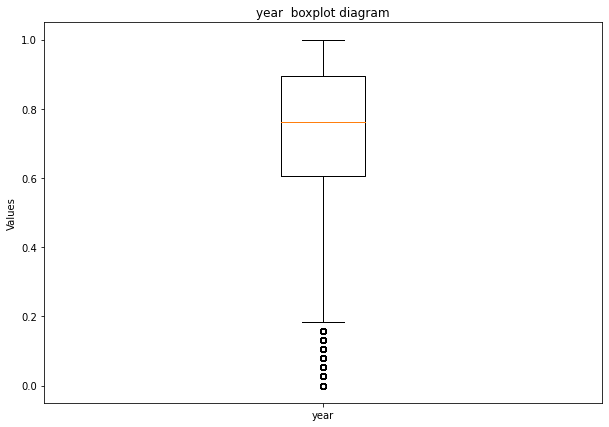

median 0.7631578947368421 mean 0.7394321787639108 min 0.0 max 1.0 total 1467793.5789473683


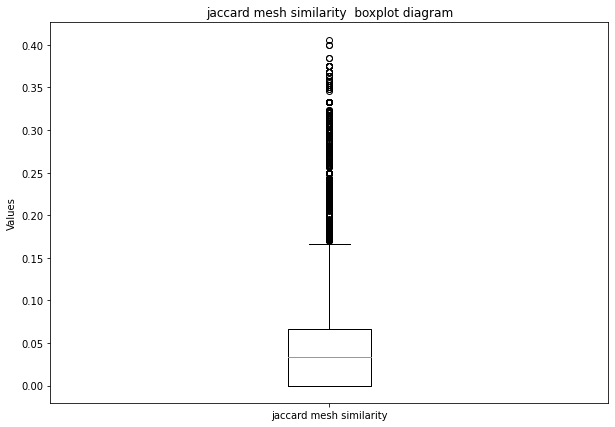

median 0.03333333333333333 mean 0.04020619331690775 min 0.0 max 0.40625 total 79570.26791479287


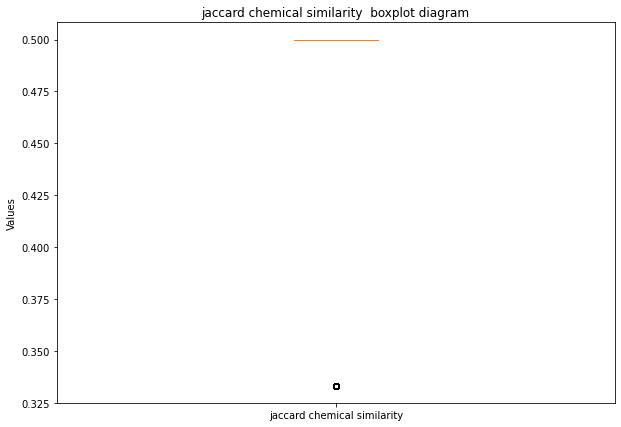

median 0.5 mean 0.47083680514224496 min 0.3333333333333333 max 0.5 total 276885.0


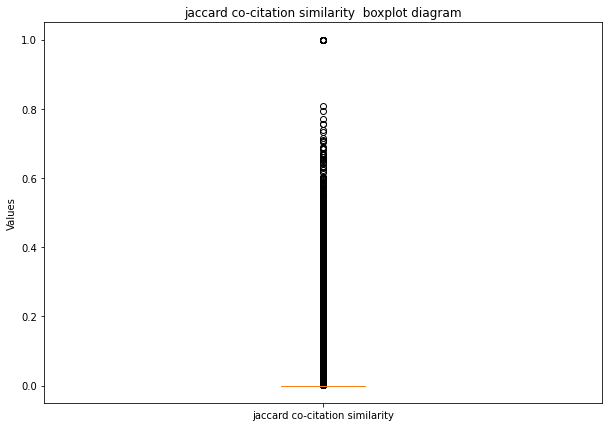

median 0.0 mean 0.008312115093559048 min 0.0 max 1.0 total 16682.46486546357


NameError: name 'cocitation_matrix' is not defined

In [64]:
#Assuming a square matrix, report statistics
def report_matrix_stats(matrix, title):
    n = matrix.shape[0]
    all_values = []
    
    for i in range(n):
        for j in range(i):
            #Remove negatives as they are flags
            if matrix[i][j] > -1:
                all_values.append(matrix[i][j])
    
    report_stats(all_values, title)
    
    
report_matrix_stats(year_similarity_matrix, 'year')

report_matrix_stats(mesh_similarity_matrix, 'jaccard mesh similarity')

report_matrix_stats(chemical_similarity_matrix, 'jaccard chemical similarity')

report_matrix_stats(cocitation_similarity_matrix, 'jaccard co-citation similarity')
report_matrix_stats(cocitation_matrix, 'raw co-citation similarity')

report_matrix_stats(bib_coupling_similarity_matrix, 'jaccard bib-coupling similarity')
report_matrix_stats(bib_coupling_matrix, 'raw bib-coupling similarity')


report_matrix_stats(aggregated_three_hop_similarity, 'aggregated three hop similarity')
report_matrix_stats(grants_similarity_matrix, 'grants similarity')

report_matrix_stats(journal_similarity_matrix, 'journal similarity')



In [ ]:
print(np.mean(grants_similarity_matrix))

for key, value in metadata_dict.items():
    if len(value['grants']) > 0:
        print(value['grants'])

In [ ]:
#Verify that those entries without grant actually do not have grants
sample_list_of_pmid_without_grant = []
without_grants_doi = []
i = 0
with_grants = []

for key, value in all_xmls.items():
    if 'grant' in str(value).lower():
        with_grants.append(key)
    
    else:
        sample_list_of_pmid_without_grant.append(key)
        without_grants_doi.append(doi_lookup_dict[key])
        
    i+= 1
    
    if i == 100:
        break

print('Statistics for first 10 papers:\n')
print(f'DOIs without grant: {without_grants_doi[0:10]}')
print(f'PMIDs without grant: {sample_list_of_pmid_without_grant[0:10]}\n')

print(f'PMID of papers with grants {with_grants}')

<h1>Example</h1>
An example of bib-couple and co-citation calculation for two nodes

In [ ]:
first_node_id = 0
first_node_pmid = nodes_array[first_node_id]

second_node_id = 50
second_node_pmid = nodes_array[second_node_id]

first_reference = {}
first_cited = {}

second_reference = {}
second_cited = {}

for edge in edge_array:
    start_node = edge[0]
    end_node = edge[1]

    if start_node == first_node_pmid:
        first_reference[end_node] = 1
    if end_node == first_node_pmid:
        first_cited[start_node] = 1     
        
    
    if start_node == second_node_pmid:
        second_reference[end_node] = 1
    if end_node == second_node_pmid:
        second_cited[start_node] = 1       

print(f'recorded bib-coupling: {bib_coupling_matrix[first_node_id][second_node_id]}')
print(f'crossed checked bib-coupling: {calculate_dict_similarity(first_reference, second_reference, mode = "number_of_common_terms")}')

print()

print(f'recorded co-citation: {cocitation_matrix[first_node_id][second_node_id]}')
print(f'crossed checked co-citation: {calculate_dict_similarity(first_cited, second_cited, mode = "number_of_common_terms")}')

<h1>Missing ISSN</h1>
Finding xml's without ISSN. Any journal info?

In [ ]:
missing_issn = []
for key, value in all_xmls.items():
    if not 'issn' in str(value).lower():
        missing_issn.append(key)
        
print(f'missing ISSN pmids {missing_issn}')
print(len(missing_issn))

<h1>Examples of co-citation similarity of 1</h1>

Interestingly, for all those of paris with jaccard_cocitation = 1, they have been only cited once! As we see below, citation counts of all of those pairs is 1. This could falsly inflate co_citation similarity. This will likely be the case with new publications.

In [ ]:
year_similarity_matrix = np.load('year_similarity_matrix.npy')
year_similarity_array = []
row_indices = []
col_indices = []

for i in range(cocitation_similarity_matrix.shape[0]):
    for j in range(i):
        if cocitation_similarity_matrix[i][j] > 0.99:
            row_indices.append(i)
            col_indices.append(j)

for idx in range(len(row_indices)):
    row = row_indices[idx]
    col = col_indices[idx]
    year_similarity_array.append(year_similarity_matrix[row][col])
    print(f'citation count of both papers: {np.sum(adj_matrix[:,row])} cocitation Jaccard similarity: {cocitation_similarity_matrix[row][col]} Pmid1:{nodes_array[row]} Pmid1:{nodes_array[col]}')


print(f'Average year similarity {np.average(year_similarity_array)} total cases {len(row_indices)}')

In [ ]:
bib_coupling_similarity_matrix = np.load('bib_coupling_similarity_matrix.npy')
cocitation_similarity_matrix = np.load('cocitation_similarity_matrix.npy')

#For co_citation of 1
first_paper_id = np.unravel_index(cocitation_similarity_matrix.argmax(), cocitation_similarity_matrix.shape)[0]
second_paper_id = np.unravel_index(cocitation_similarity_matrix.argmax(), cocitation_similarity_matrix.shape)[1]

first_node_pmid =  nodes_array[first_paper_id]
second_node_pmid =  nodes_array[second_paper_id]

first_cited = []
second_cited = []



for edge in edge_array:
    start_node = edge[0]
    end_node = edge[1]

    if end_node == first_node_pmid:
        first_cited.append(start_node)   
        
    if end_node == second_node_pmid:
        second_cited.append(start_node)
        

print(f'first paper pmid: {first_node_pmid} second paper pmid: {second_node_pmid}. Citing list:\n')
print(first_cited)

#Assert two arrays are equal
assert np.sum(np.sort(first_cited) - np.sort(second_cited)) == 0


<h1>Examples of bib-coupling similarity of 1</h1>

Here the situation is differen. As we expect, reference list is typically larger than 1.

In [ ]:
row_indices, col_indices = np.where(bib_coupling_similarity_matrix == 1)
year_similarity_array = []
row_indices = []
col_indices = []


for i in range(bib_coupling_similarity_matrix.shape[0]):
    for j in range(i):
        if bib_coupling_similarity_matrix[i][j] > 0.99:
            row_indices.append(i)
            col_indices.append(j)
            
            
for idx in range(len(row_indices)):
    row = row_indices[idx]
    col = col_indices[idx]
    year_similarity_array.append(year_similarity_matrix[row][col])
    print(f' Reference count of both papers: {np.sum(adj_matrix[row, :])} Bib-coupling Jaccard similarity: {bib_coupling_similarity_matrix[row][col]} Pmid1:{nodes_array[row]} Pmid1:{nodes_array[col]}')
#print(f'citation count of both papers: {np.sum(adj_matrix[:,row])} Pmid1:{nodes_array[row]} Pmid1:{nodes_array[col]}')

print(f'Average year similarity {np.average(year_similarity_array)}, total cases: {len(row_indices)}')

In [ ]:
bib_coupling_similarity_matrix = np.load('bib_coupling_similarity_matrix.npy')
cocitation_similarity_matrix = np.load('cocitation_similarity_matrix.npy')

#For co_citation of 1
first_paper_id = row_indices[3]
second_paper_id = col_indices[3]


first_node_pmid =  3945365 #nodes_array[first_paper_id]
second_node_pmid =  11916530 #nodes_array[second_paper_id]

first_reference = []
second_reference = []



for edge in edge_array:
    start_node = edge[0]
    end_node = edge[1]

    if start_node == first_node_pmid:
        first_reference.append(end_node)   
        
    if start_node == second_node_pmid:
        second_reference.append(end_node)
        

print(f'first paper pmid: {first_node_pmid} second paper pmid: {second_node_pmid}. total references: {len(first_reference)} Reference list:\n')
print(first_reference)

#Assert two arrays are equal
assert np.sum(np.sort(first_reference) - np.sort(second_reference)) == 0


<h1> Missing grants </h1>
<p>Let's see how those samples with 'grant' string but no grant data look like </p>

In [ ]:
target_pmids = []

for key, value in all_xmls.items():
    if 'grantlist' in str(value).lower() and len(metadata_dict[key]['grants']) == 0:
        target_pmids.append(key)
        
print(target_pmids)

Through better parsing, this number is now very low!
Now the case of this 3:
<html>
<head>
    <title>PMID and Reason for Missing</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>PMID</th>
            <th>Reason for Missing</th>
        </tr>
        <tr>
            <td>1971008</td>
            <td>No grant Id, only agency and country</td>
        </tr>
    </table>
</body>
</html>

<h1>Missing Mesh</h1> 

In [58]:
target_pmids = []

for key, value in all_xmls.items():
    if not'meshheadinglist' in str(value).lower() and len(str(all_xmls[key])) > 250:
        target_pmids.append(key)
        
print(target_pmids)

['9965650', '10061152', '5277976']


As we verify manually, these 3 articles don't have any mesh term inside them. So, out of 1993 parsable responses, only 3 miss mesh information.